In [1]:
from pnet import pnet_loader, Pnet, ReactomeNetwork
from util import util, sankey_diag

import torch
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch.nn as nn
from scipy.stats import bernoulli
import networkx as nx

%load_ext autoreload
%autoreload 2

/opt/conda/envs/pnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
gene_cn = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_gene_cn.csv').set_index('Unnamed: 0')
gene_cn.rename(columns=dict(zip(gene_cn.columns, [x.split(' ')[0] for x in gene_cn.columns])), inplace=True)

muts = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_mutations.csv')
muts.dropna(subset=['Variant_Classification'], inplace=True)

MUTATIONS_DICT = util.MUTATIONS_DICT

grouped_muts = muts[muts['Variant_Classification'].apply(lambda x: MUTATIONS_DICT[x]) != 'Silent'][['Hugo_Symbol',
                                                                                                    'Variant_Classification',
                                                                                                    'Tumor_Sample_Barcode']].groupby(['Tumor_Sample_Barcode',
                                                                                                                                          'Hugo_Symbol']).count()
mut = grouped_muts.unstack(level=-1).fillna(0).droplevel(0, axis=1)

p53_target = pd.DataFrame(mut['TP53'] > 0).astype(int)
p53_target.rename(columns=dict.fromkeys(['TP53'],'TP53_mut'), inplace=True)

rna = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_expression_full.csv').set_index('Unnamed: 0')
rna.rename(columns=dict(zip(rna.columns, [x.split(' ')[0] for x in rna.columns])), inplace=True)

canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))
canc_genes.remove('TP53')
canc_genes.remove('KMT2D')

genetic_data = {'rna': rna, 'mut': mut}

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (5,21,27,28,29,30,31,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Let's see if we can regenerate the important link in 'Deubiquitination (R-HSA-5688426)' in the pathway layer 2. First of all, when we drop the link we should see a slight drop in performance of the network since it was robbed one of it's more important predictors.

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Found 705 overlapping genes
removed:  Transcriptional Regulation by TP53
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Found 705 overlapping genes
removed:  Transcriptional Regulation by TP53
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input moda

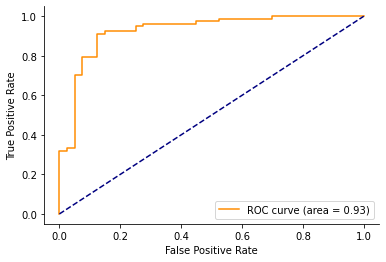

In [55]:
class_weights = util.get_class_weights(torch.tensor(p53_target.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/ccle/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/ccle/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, p53_target, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=64, epochs=400, early_stopping=True, 
                                                                             loss_weight=class_weights, train_inds=train_inds, test_inds=test_inds,
                                                                             save_path='../results/ccle_pathway_drop/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes,
                                                                             drop_pathways=['Transcriptional Regulation by TP53'])
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ccle_pathway_drop/run{}'.format(i))

In [57]:
auc_df = pd.DataFrame()
models = ['ccle_val', 'ccle_pathway_drop']
for mod in models:
    aucs = []
    for i in range(10):
        auc = torch.load('../results/{}/run{}/AUC.pt'.format(mod, i))
        aucs.append(auc.item())
    auc_df[mod] = aucs

auc_df = auc_df[auc_df.mean().sort_values(ascending=False).index]
auc_df.rename(columns={'prostate_val': 'P-Net', 'pathway_drop': 'P-Net \n with dropped Pathway'}, inplace=True)

auc_df.mean()

ccle_pathway_drop    0.912148
ccle_val             0.907241
dtype: float64

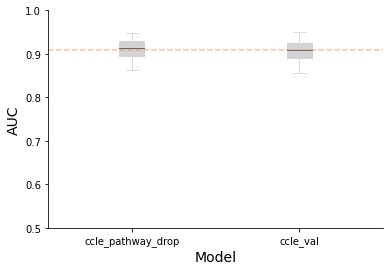

In [58]:
auc_df.plot(kind='box', showfliers=False, patch_artist=True, boxprops={'facecolor': 'lightgrey', 'color': 'lightgrey'},
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
plt.axhline(y=auc_df.median().min(), color='coral', linestyle='--', label=f'y_min = {auc_df.median().min()}', alpha=0.5)
ax.set_ylabel('AUC', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/pnet_performance_pathway_drop_AUC.pdf')

In [60]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, p53_target, gene_set=canc_genes)

reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (828, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (355, 1410)
Found 705 overlapping genes


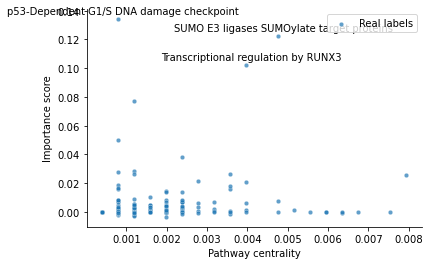

In [71]:
df_imps_prostate = pd.DataFrame()
df_ranks_prostate = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/ccle_pathway_drop/run{}/layer_1_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = imps.join(p53_target).groupby('TP53_mut').mean().diff(axis=0).iloc[1]
    # imps = imps.mean()
    ranks = imps.rank(ascending=False)
    df_imps_prostate['run{}'.format(i)] = imps
    df_ranks_prostate['run{}'.format(i)] = ranks
df_imps_prostate = df_imps_prostate.loc[[i for i in df_imps_prostate.index if i.split('.')[-1] != '1']]    

centrality_df = pd.DataFrame.from_dict(nx.degree_centrality(reactome_network.graph), orient='index')
enc_dict = reactome_network.pathway_encoding.set_index('ID')['pathway']
enc_dict['root'] = 'root'
centrality_df.index = centrality_df.index.map(lambda x: enc_dict[x])
centrality_df = centrality_df[~centrality_df.index.duplicated(keep='first')]
    
plotting_df = pd.DataFrame()
plotting_df['prostate_imps'] = df_imps_prostate.mean(axis=1)
plotting_df['centrality'] = centrality_df.loc[plotting_df.index]

sns.scatterplot(data=plotting_df, x='centrality', y='prostate_imps', s=20, alpha=0.7)
for index, row in plotting_df.iterrows():
    if abs(row['prostate_imps']) > 0.1:
        plt.annotate(index, (row['centrality'], row['prostate_imps']), textcoords="offset points", xytext=(5,5), ha='center')

sns.despine()
plt.legend(['Real labels', 'Random labels'])
plt.ylabel('Importance score')
plt.xlabel('Pathway centrality')
# plt.savefig('../figures/layer1_imp_vs_connections.pdf')
plt.show()